In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_moons
from sklearn.utils import shuffle

In [2]:
n = 10016
batch_size = 32

In [3]:
X, Y = make_moons(n_samples=n, noise=0.1)
X, Y = shuffle(X, Y, random_state=72)

In [4]:
Xs = []
Ys = []
batch_num = int(np.ceil(len(X) / batch_size))

In [5]:
for i in range(batch_num):
    start = i * batch_size
    end = start + batch_size
    Xs.append(X[start:end])
    Ys.append(Y[start:end])

In [6]:
Xs = np.array(Xs).reshape(batch_num, batch_size, 2, 1)
Ys = np.array(Ys).reshape(batch_num, batch_size, 1, 1)
X = X.reshape(n, 2, 1)
Y = Y.reshape(n, 1, 1)

In [7]:
size = [2, 10, 5, 1]

In [8]:
weights = [0]
biases = [0]
for i in range(0, len(size) - 1):
    weights.append(np.random.rand(size[i + 1], size[i]))
    biases.append(np.random.rand(size[i + 1], 1))

In [9]:
weights

[0,
 array([[0.10843794, 0.97979506],
        [0.46043062, 0.95748219],
        [0.69135931, 0.20393592],
        [0.52683045, 0.24217368],
        [0.01169848, 0.68005853],
        [0.34339836, 0.36101712],
        [0.4132722 , 0.50000851],
        [0.09700505, 0.48269826],
        [0.63394693, 0.34181098],
        [0.15798041, 0.96537045]]),
 array([[0.16372817, 0.19547245, 0.19821409, 0.59175102, 0.24479244,
         0.34896877, 0.27113413, 0.34326247, 0.00198365, 0.70929058],
        [0.52917801, 0.54179493, 0.8026632 , 0.67228601, 0.09779349,
         0.76037374, 0.29641523, 0.4499852 , 0.25857541, 0.32101212],
        [0.83999027, 0.7586235 , 0.88374424, 0.97677168, 0.64791051,
         0.57409534, 0.77870928, 0.86986726, 0.82718105, 0.829739  ],
        [0.54396414, 0.46676534, 0.21993159, 0.85211074, 0.37284147,
         0.55935694, 0.43045487, 0.88657047, 0.26413954, 0.72977878],
        [0.60798164, 0.16874153, 0.11744132, 0.76499602, 0.69504301,
         0.74650378, 0.576227

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
def L(y_hat, y):
    return 0.5 * (y_hat - y) ** 2

In [12]:
def feed_forward(xi, weights, biases):
    activations = [xi]
    z1 = weights[1] @ xi + biases[1]
    a1 = sigmoid(z1)
    activations.append(a1)
    for i in range(2, len(weights)):
        zn = weights[i] @ activations[-1] + biases[i]
        an = sigmoid(zn)
        activations.append(an)
    return activations

In [13]:
def sigmoid_derivative(y):
    return y * ( 1 - y )

In [14]:
def backprop(weights, biases, xi, y, activations):
    deltas = [0] * len(activations)
    dL_dwK = [0] * len(activations)
    dL_dbK = [0] * len(activations)

    deltas[-1] = ( activations[-1] - y ) * sigmoid_derivative(activations[-1])
    dL_dwK[-1] = deltas[-1] @ activations[-1].T
    dL_dbK[-1] = deltas[-1]

    for i in range(len(deltas)-2, 0, -1):
        deltas[i] = ( weights[i+1].T @ deltas[ i + 1 ] ) * sigmoid_derivative(activations[i])
        dL_dwK[i] = deltas[i] @ activations[ i - 1 ].T
        dL_dbK[i] = deltas[i]

    return dL_dwK, dL_dbK

In [15]:
act = feed_forward(Xs[0][2], weights, biases)
print(act)
bc = backprop(weights, biases, Xs[0][2], Ys[0][2], act)[0]
for w in bc:
    if type(w) is not int: print(w.shape)

[array([[ 0.82479657],
       [-0.37583189]]), array([[0.45867659],
       [0.72381069],
       [0.6762169 ],
       [0.64443658],
       [0.66792452],
       [0.72253763],
       [0.58603857],
       [0.7062629 ],
       [0.62329067],
       [0.50070688]]), array([[0.92034138],
       [0.98076399],
       [0.99592571],
       [0.9761888 ],
       [0.97556486]]), array([[0.87715287]])]
(10, 2)
(5, 10)
(1, 1)


In [16]:
epochs = 20
lr = 0.1
loss = []
pm, pv, t = 0, 0, 1

In [17]:
def adam(weight_bias_derivative, weight, learning_rate, previous_moment, previous_velocity, t, beta_1=0.8, beta_2=0.95, epsilon=10**-8):
    gt = weight_bias_derivative
    mt = beta_1 * previous_moment + (1 - beta_1) * gt
    vt = beta_2 * previous_velocity + (1 - beta_2) * gt ** 2
    mt_hat = mt/(1 - beta_1**t)
    vt_hat = vt/(1 - beta_2**t)
    ret = weight - (learning_rate*mt_hat)/(np.sqrt(vt_hat)+epsilon)
    return ret, np.linalg.norm(mt), np.linalg.norm(vt), t+1

In [18]:
for i in tqdm(range(epochs)):
    epochloss = 0
    for j in range(batch_num):
        for i, xi in enumerate(Xs[j]):
            activations = feed_forward(xi, weights, biases)
            epochloss += L(activations[-1], Ys[j,i])

            dL_dw, dL_db = backprop(weights, biases, xi, Ys[j,i], activations)

            for i, w in enumerate(weights):
                #w -= lr * dL_dw[i]
                w, pm, pv, t = adam(dL_dw[i], w, lr, pm, pv, t)
            for i, b in enumerate(biases):
                b -= lr * dL_db[i]

    loss.append(epochloss / n)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-17-7377bc228b66>:7: RuntimeWarning: invalid value encountered in divide
  ret = weight - (learning_rate*mt_hat)/(np.sqrt(vt_hat)+epsilon)
<ipython-input-17-7377bc228b66>:7: RuntimeWarning: invalid value encountered in scalar divide
  ret = weight - (learning_rate*mt_hat)/(np.sqrt(vt_hat)+epsilon)
100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


In [19]:
weights

[0,
 array([[0.10843794, 0.97979506],
        [0.46043062, 0.95748219],
        [0.69135931, 0.20393592],
        [0.52683045, 0.24217368],
        [0.01169848, 0.68005853],
        [0.34339836, 0.36101712],
        [0.4132722 , 0.50000851],
        [0.09700505, 0.48269826],
        [0.63394693, 0.34181098],
        [0.15798041, 0.96537045]]),
 array([[0.16372817, 0.19547245, 0.19821409, 0.59175102, 0.24479244,
         0.34896877, 0.27113413, 0.34326247, 0.00198365, 0.70929058],
        [0.52917801, 0.54179493, 0.8026632 , 0.67228601, 0.09779349,
         0.76037374, 0.29641523, 0.4499852 , 0.25857541, 0.32101212],
        [0.83999027, 0.7586235 , 0.88374424, 0.97677168, 0.64791051,
         0.57409534, 0.77870928, 0.86986726, 0.82718105, 0.829739  ],
        [0.54396414, 0.46676534, 0.21993159, 0.85211074, 0.37284147,
         0.55935694, 0.43045487, 0.88657047, 0.26413954, 0.72977878],
        [0.60798164, 0.16874153, 0.11744132, 0.76499602, 0.69504301,
         0.74650378, 0.576227

In [20]:
loss

[array([[0.12705608]]),
 array([[0.12572276]]),
 array([[0.1256684]]),
 array([[0.12563055]]),
 array([[0.12560284]]),
 array([[0.12558172]]),
 array([[0.12556509]]),
 array([[0.12555165]]),
 array([[0.12554055]]),
 array([[0.1255312]]),
 array([[0.12552319]]),
 array([[0.12551625]]),
 array([[0.12551014]]),
 array([[0.12550471]]),
 array([[0.12549983]]),
 array([[0.12549541]]),
 array([[0.12549136]]),
 array([[0.12548762]]),
 array([[0.12548414]]),
 array([[0.12548089]])]

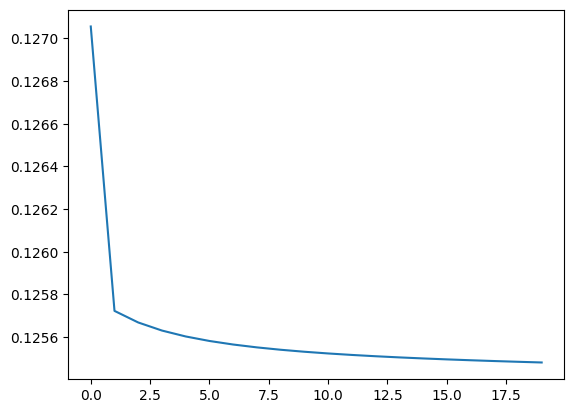

In [21]:
xcoord = np.array([n for n in range(epochs)]).reshape(20, 1)
ycoord = np.array(loss).reshape(20, 1)
plt.plot(xcoord, ycoord)
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('loss1.png')

In [22]:
def evaluate_visually(x, w, b):
    rb = []
    for xi in x:
        predictions = feed_forward(xi, w, b)
        if predictions[-1] <= 0.5: rb.append('red')
        else: rb.append('blue')
    return rb

In [23]:
rb = evaluate_visually(X.reshape(n, 2, 1), weights, biases)

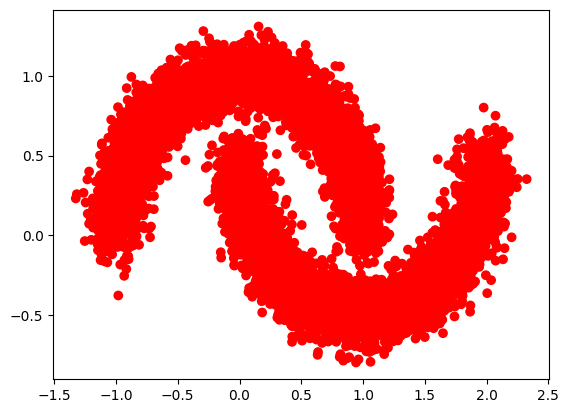

In [24]:
plt.scatter(Xs[:,:,0,:], Xs[:,:,1,:], c=rb)
plt.savefig('prediction1.png')

In [25]:
def evaluate_errors(x, w, b, y):
    rb = []
    for i, xi in enumerate(x):
        p = 0
        predictions = feed_forward(xi, w, b)
        if predictions[-1] <= 0.5: p = 0
        else: p = 1
        if p == Y[i, 0]:
            rb.append('gray')
        else: rb.append('red')
    return rb

In [26]:
br = evaluate_errors(X, weights, biases, Y)

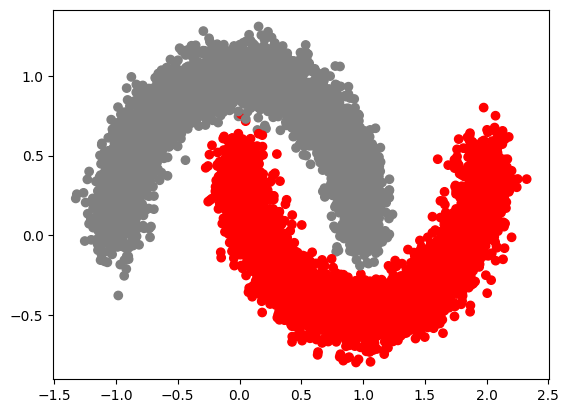

In [27]:
plt.scatter(X[:,0,:], X[:,1,:], c=br)

In [28]:
inc = 0
for c in br:
    if c == 'red': inc += 1
print(f'Training Accuracy {inc} / {n} : {((n-inc)/n)*100:.2f}%')

Training Accuracy 5008 / 10016 : 50.00%
